# PyTorch Tutorial

In [1]:
# print progress, possibly faster than progress bar
def print_progress(epoch, batch_id, accuracy, loss):
    progress = '='* int((10. * batch_id / len(train_data)))
    progress += '>'
    if batch_id == 1:
        print('Train Epoche {}: {}% [{}]\t accuracy: {:.6f}, loss: {:.6f}'.format(
            epoch, 100. * batch_id / len(train_data),progress, accuracy, loss.item()), end='')
    else:
        print('\rTrain Epoche {}: {}% [{}]\t accuracy: {:.6f}, loss: {:.6f}'.format(
            epoch, 100. * batch_id / len(train_data),progress, accuracy, loss.item()), end='', flush = True)

### Progress bar

In [2]:
from tqdm import trange
from time import sleep

def get_divisors(n):
    divisors = []
    for m in range(1, n+1):
        if n % m == 0:
            divisors.append(m)
    return divisors

iterations = 10
with trange(iterations, unit="carrots") as pbar:
    for i in pbar:
        sleep(0.5)
        if i % 2:
            pbar.set_description(f"Testing odd number {i}")
        else:
            pbar.set_description(f"Testing even number {i}")
        pbar.set_postfix(divisors=get_divisors(i))

Testing odd number 9: 100%|███████████████████████████████████| 10/10 [00:05<00:00,  1.97carrots/s, divisors=[1, 3, 9]]


### First network

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
from scipy import io
import os

# Tutorial: https://www.youtube.com/watch?v=GBzojftwfGQ&list=PLNmsVeXQZj7rx55Mai21reZtd_8m-qe27&index=5&ab_channel=TheMorpheusTutorials
# 1. Tensor
x = torch.Tensor(5,3)   # numpy arrays werden durch Tensoren ersetzt
x[:,:] = 1
y = torch.randn(5,3)    # random tenseor
#print(y)
xy = torch.add(x,y)
print(xy)

# 2. Für Grafik Karte
#if torch.cuda.is_available():
#    x = x.cuda()       # RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable 
#    y = y.cuda()
#print(x+y)
torch.cuda.empty_cache()
a_full = torch.randn(5024, 1024, dtype=torch.double, device='cuda')
b_full = torch.randn(1024, 5024, dtype=torch.double, device='cuda')
ab_full = a_full @ b_full
mean = ab_full.abs().mean()  # 80.7277

a = a_full.float()
b = b_full.float()

# Do matmul at TF32 mode.
ab_tf32 = a @ b  # takes 0.016s on GA100
error = (ab_tf32 - ab_full).abs().max()  # 0.1747
relative_error = error / mean  # 0.0022
print(error, relative_error)

# Do matmul with TF32 disabled.
torch.backends.cuda.matmul.allow_tf32 = False
ab_fp32 = a @ b  # takes 0.11s on GA100
error = (ab_fp32 - ab_full).abs().max()  # 0.0031
relative_error = error / mean  # 0.000039
print(error, relative_error)


# 3. Daten laden 
kwargs = {}
train_data = torch.utils.data.DataLoader(datasets.MNIST('data_figures_nn', train=True, download=True, 
                                                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3082,))])),
                                    batch_size=64, shuffle=True, **kwargs)
# Bilder laden und verarbeiten
from PIL import Image
from torchvision import transforms
from os import listdir
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])    # normalize around mean with sigma (std)
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(256), transforms.ToTensor(), normalize])
train_data_list = []
train_data = []
target_label = []
for f in listdir('catdog/train/'):        # choose your datasource
    img = Image.open('catdog/train/' + f)
    img_tensor = transforms(img)
    img_tensor.unsqueeze_(0)   # save directly in img_tensor with _ at the end (1,3,256,256)
    # label
    isCat = 1 if 'cat' in f else 0
    isDog = 1 if 'dog' in f else 0
    target = [isCat, isDog]
    target_label.append(target)
    if len(train_data_list) >= 64:
        train_data.append(torch.stack(train_data_list), target_label)
        train_data_list = []
        break




tensor([[1.9733, 1.6265, 2.4631],
        [1.7833, 0.7271, 0.1025],
        [0.8165, 1.9885, 2.2756],
        [0.1511, 1.4171, 0.6514],
        [1.5482, 2.5004, 0.0784]])


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'catdog/train/'

In [6]:
# 4. Erste eigene Neuronale Netzwerk
class MyNet(nn.Module): # Vererbungslehre
    def __init__(self):              # initialize network
        super(MyNet,self).__init__()
        self.lin1 = nn.Linear(10,10)
        self.lin2 = nn.Linear(10,10)
    
    def forward(self, x):            # forward pass function
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def num_flat_features(self,x):
        size = x.size() [1:]         # ohne batch dimension
        num = 1
        for i in size:
            num *= i
        return num
    
net = MyNet()
#net = net.cuda()
print(net)

MyNet(
  (lin1): Linear(in_features=10, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
)


In [7]:
# 5. main training loop with input
for i in range(100):
    x = [0,1,1,1,0,1,1,1,0,0]
    input = Variable(torch.Tensor([x for _ in range(10)]))    # 10x10 input variable, weil man ein batch von 10 daraus erstellt
    out = net(input)                      # input durch Netz durchlaufen lassen

    # labels what to expect
    x = [1,0,0,0,1,0,0,0,1,1]
    target = Variable(torch.Tensor([x for _ in range(10)]))
    # loss
    criterion = nn.MSELoss()              # Fehlerfunktionen: optimieren (softwmax, MSE, ...)
    loss = criterion(out, target)
    print(loss)

    net.zero_grad()
    loss.backward()
    optimizer = optim.SGD(net.parameters(), lr=0.1,)            # optimizer ausprobieren SGD, Adam, ...
    optimizer.step()
    y
    
test_input = Variable(torch.Tensor([1,1,1,1,0,0,0,1,1,1]))
test_out = net(test_input)
print(test_out)  

print(out)

# 6. Speichern und Laden des Trainierten Netzes (pro Zyklus speichern, falls das Programm abstürtzt während dem trainieren)
torch.save(net, 'data_figures_nn/MyNet.pt')
if os.path.isfile('data_figures_nn/MyNet.pt'):
    net_load = torch.load('data_figures_nn/MyNet.pt')

print(net_load)


tensor(0.5861, grad_fn=<MseLossBackward0>)
tensor(0.5043, grad_fn=<MseLossBackward0>)
tensor(0.4419, grad_fn=<MseLossBackward0>)
tensor(0.3914, grad_fn=<MseLossBackward0>)
tensor(0.3489, grad_fn=<MseLossBackward0>)
tensor(0.3118, grad_fn=<MseLossBackward0>)
tensor(0.2787, grad_fn=<MseLossBackward0>)
tensor(0.2487, grad_fn=<MseLossBackward0>)
tensor(0.2213, grad_fn=<MseLossBackward0>)
tensor(0.1973, grad_fn=<MseLossBackward0>)
tensor(0.1764, grad_fn=<MseLossBackward0>)
tensor(0.1567, grad_fn=<MseLossBackward0>)
tensor(0.1383, grad_fn=<MseLossBackward0>)
tensor(0.1214, grad_fn=<MseLossBackward0>)
tensor(0.1058, grad_fn=<MseLossBackward0>)
tensor(0.0917, grad_fn=<MseLossBackward0>)
tensor(0.0790, grad_fn=<MseLossBackward0>)
tensor(0.0678, grad_fn=<MseLossBackward0>)
tensor(0.0578, grad_fn=<MseLossBackward0>)
tensor(0.0492, grad_fn=<MseLossBackward0>)
tensor(0.0416, grad_fn=<MseLossBackward0>)
tensor(0.0352, grad_fn=<MseLossBackward0>)
tensor(0.0296, grad_fn=<MseLossBackward0>)
tensor(0.02

### MNIST example

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import time
import os

kwargs = {}          # without GPU
#kwargs = {'num_workers': 1, 'pin_memory': True}        # with GPU
batch_size=64
train_data = torch.utils.data.DataLoader(datasets.MNIST('data_figures_nn', train=True, download=True, 
                                                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3082,))])),
                                    batch_size=64, shuffle=True, **kwargs)    # shuffle that network don't learns repetition, kwargs are arguments for the function (has to be written)  
print(len(train_data.dataset))

test_data = torch.utils.data.DataLoader(datasets.MNIST('data_figures_nn', train=False, download=True, 
                                                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3082,))])),
                                    batch_size=64, shuffle=True, **kwargs)    # shuffle that network don't learns repetition, kwargs are arguments for the function (has to be written)  
print(train_data.dataset)

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        # definition of object layers
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)    # (in_channels: Eingangsdimension, out_channels: Ausgangsdimension)
        # (kernel_size: Faltungsfiltergrösse, stride: #Schritte der Faltung (reduziert Dimension), padding: Leerer Rand dass Dimension weniger abnimmt, dilation: adding zeros between kernel, groups: , bias: added to output, padding_mode='zeros')
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        # (p=0.5: probability for dropout, inplace: if True input layer gets changed)
        self.conv_dropout = nn.Dropout2d()            # damit das Netz nichts auswendig lernt
        self.fc1 = nn.Linear(320, 60)
        self.fc2 = nn.Linear(60, 10)
    
    def forward(self,x):
        # actual layer composition
        #print('start:',x.shape)
        x = self.conv1(x)
        #print('conv1:', x.shape)
        # (kernel_size, stride, padding, dilation, return_indices: of max value if True, ceil_mode: ceil if True (aufrunden))
        x = F.max_pool2d(x, 2)
        #print('pool1:', x.shape)
        x = F.relu(x)
        #print('relu1:',x.shape)
        x = self.conv2(x)
        #print('conv2:',x.shape)
        x = self.conv_dropout(x)
        #print('dropout:',x.shape)
        x = F.max_pool2d(x, 2)
        #print('pool2:',x.shape)
        x = F.relu(x)
        print('relu2:', x.size())
        x = x.view(-1,320)        # daten umformen
        print('view:', x.size())
        x = F.relu(self.fc1(x))
        #print('relu3_fc1:', x.shape)
        x = self.fc2(x)
        #print('fc2:', x.shape)
        
        return F.log_softmax(x, dim=1)
    
if os.path.isfile('data_figures_nn/MyNet_MNIST.pt'):
    net = torch.load('data_figures_nn/MyNet_MNIST.pt')       

# model
model = net()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.8)   # momentum [0,1]


# training
def train(epoch):
    model.train()
    #model.eval()
    with tqdm(train_data, unit="batch") as tepoch:
        # in our train data we have the pictures (data), target number 1-9 and bates of size 64 in this case
        for (data, target) in tepoch:
            #data = data.cuda()
            #target = target.cuda()
            #data = Variable(data)
            #target = Variable(target)
            optimizer.zero_grad()
            
            # forward pass
            out = model(data)
            
            #calculate loss
            loss = F.nll_loss(out, target)          # criterion = nn.CrossEntropyLoss() + loss = criterion(out, target), F.nll_loss is better
            predictions = out.argmax(dim=1, keepdim=True).squeeze()
            correct = (predictions == target).sum().item()
            accuracy = correct / batch_size
            
            loss.backward()
            optimizer.step()
            
            # display training progress
            #print_progress(epoch, batch_id, accuracy, loss)      # faster?
            tepoch.set_description(f"Epoch {epoch}")
            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy)
            #time.sleep(0.1)
            torch.save(net, 'data_figures_nn/MyNet_MNIST.pt')

def test():
    model.eval()
    loss = 0
    correct = 0
    for data, target in test_data:
        out = model(data)
        loss += F.nll_loss(out, target, size_average=False).item()
        prediction = out.data.max(1, keepdim=True)[1]
        correct += prediction.eq(target.data.view_as(prediction)).sum()
    
    loss = loss / len(test_data.dataset)
    print('average loss: ', loss)
    print('accuracy: ', int(100.*correct/len(test_data.dataset)), '%')
        
    
for epoch in range(1,3):
        train(epoch)
        test()
        


60000
Dataset MNIST
    Number of datapoints: 60000
    Root location: data_figures_nn
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3082,))
           )


Epoch 1:   0%|▏                                           | 3/938 [00:00<00:39, 23.69batch/s, accuracy=14.1, loss=2.31]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   0%|▏                                           | 3/938 [00:00<00:39, 23.69batch/s, accuracy=15.6, loss=2.29]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:   1%|▍                                          | 10/938 [00:00<00:31, 29.08batch/s, accuracy=26.6, loss=2.23]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   1%|▍                                          | 10/938 [00:00<00:31, 29.08batch/s, accuracy=29.7, loss=2.09]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:   1%|▌                                          | 13/938 [00:00<00:31, 29.28batch/s, accuracy=45.3, loss=1.73]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:   2%|▊                                          | 17/938 [00:00<00:31, 29.28batch/s, accuracy=46.9, loss=1.73]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   2%|▉                                          | 21/938 [00:00<00:30, 29.67batch/s, accuracy=59.4, loss=1.36]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:   3%|█                                         | 25/938 [00:00<00:30, 29.92batch/s, accuracy=73.4, loss=0.747]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   3%|█▏                                            | 25/938 [00:00<00:30, 29.92batch/s, accuracy=75, loss=1.1]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:   3%|█▎                                         | 28/938 [00:01<00:30, 29.48batch/s, accuracy=57.8, loss=1.23]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:   3%|█▍                                        | 31/938 [00:01<00:30, 29.57batch/s, accuracy=71.9, loss=0.962]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:   4%|█▌                                        | 35/938 [00:01<00:29, 30.20batch/s, accuracy=67.2, loss=0.981]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   4%|█▋                                        | 39/938 [00:01<00:29, 30.44batch/s, accuracy=70.3, loss=0.898]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   5%|█▉                                        | 43/938 [00:01<00:29, 30.35batch/s, accuracy=73.4, loss=0.887]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   5%|██                                        | 47/938 [00:01<00:28, 30.90batch/s, accuracy=79.7, loss=0.562]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   5%|██▎                                          | 47/938 [00:01<00:28, 30.90batch/s, accuracy=75, loss=0.82]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   5%|██▎                                       | 51/938 [00:01<00:28, 30.81batch/s, accuracy=78.1, loss=0.672]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:   6%|██▍                                       | 55/938 [00:01<00:27, 31.57batch/s, accuracy=79.7, loss=0.638]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   6%|██▋                                       | 59/938 [00:01<00:27, 31.50batch/s, accuracy=87.5, loss=0.361]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   6%|██▋                                       | 59/938 [00:02<00:27, 31.50batch/s, accuracy=76.6, loss=0.534]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   7%|██▊                                       | 63/938 [00:02<00:27, 31.30batch/s, accuracy=84.4, loss=0.472]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   7%|███                                       | 67/938 [00:02<00:28, 30.87batch/s, accuracy=81.2, loss=0.655]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   8%|███▏                                      | 71/938 [00:02<00:27, 31.01batch/s, accuracy=78.1, loss=0.558]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   8%|███▏                                      | 71/938 [00:02<00:27, 31.01batch/s, accuracy=82.8, loss=0.463]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   8%|███▎                                      | 75/938 [00:02<00:27, 30.89batch/s, accuracy=81.2, loss=0.519]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   8%|███▌                                      | 79/938 [00:02<00:27, 31.09batch/s, accuracy=81.2, loss=0.685]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   9%|███▋                                      | 83/938 [00:02<00:27, 31.24batch/s, accuracy=73.4, loss=0.855]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   9%|███▊                                       | 83/938 [00:02<00:27, 31.24batch/s, accuracy=78.1, loss=0.63]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:   9%|███▉                                      | 87/938 [00:02<00:26, 31.63batch/s, accuracy=89.1, loss=0.401]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  10%|████▎                                       | 91/938 [00:02<00:26, 31.70batch/s, accuracy=84.4, loss=0.6]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  10%|████▎                                     | 95/938 [00:03<00:26, 31.29batch/s, accuracy=89.1, loss=0.435]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  10%|████▎                                     | 95/938 [00:03<00:26, 31.29batch/s, accuracy=87.5, loss=0.726]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  11%|████▍                                     | 99/938 [00:03<00:26, 32.05batch/s, accuracy=92.2, loss=0.456]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  11%|████▌                                    | 103/938 [00:03<00:25, 32.37batch/s, accuracy=87.5, loss=0.422]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  11%|████▋                                    | 107/938 [00:03<00:26, 31.88batch/s, accuracy=78.1, loss=0.575]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  11%|████▋                                    | 107/938 [00:03<00:26, 31.88batch/s, accuracy=70.3, loss=0.616]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  12%|█████                                    | 115/938 [00:03<00:25, 32.45batch/s, accuracy=79.7, loss=0.566]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  12%|█████                                    | 115/938 [00:03<00:25, 32.45batch/s, accuracy=84.4, loss=0.355]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  13%|█████▏                                   | 119/938 [00:03<00:24, 32.98batch/s, accuracy=84.4, loss=0.549]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  13%|█████▋                                     | 123/938 [00:03<00:24, 32.95batch/s, accuracy=75, loss=0.541]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  14%|█████▌                                   | 127/938 [00:04<00:25, 32.27batch/s, accuracy=82.8, loss=0.454]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  14%|█████▌                                   | 127/938 [00:04<00:25, 32.27batch/s, accuracy=81.2, loss=0.731]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])

Epoch 1:  14%|█████▋                                   | 131/938 [00:04<00:25, 31.83batch/s, accuracy=87.5, loss=0.438]


view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  14%|█████▉                                   | 135/938 [00:04<00:25, 31.68batch/s, accuracy=79.7, loss=0.653]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  15%|██████                                   | 139/938 [00:04<00:25, 31.42batch/s, accuracy=76.6, loss=0.796]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  15%|██████                                   | 139/938 [00:04<00:25, 31.42batch/s, accuracy=89.1, loss=0.324]

relu2: torch.Size([64, 20, 4, 4])
view: 

Epoch 1:  16%|██████▍                                  | 147/938 [00:04<00:24, 31.84batch/s, accuracy=85.9, loss=0.354]

torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  16%|██████▌                                  | 151/938 [00:04<00:24, 31.69batch/s, accuracy=89.1, loss=0.462]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  17%|███████▍                                    | 159/938 [00:05<00:24, 31.78batch/s, accuracy=75, loss=1.08]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  17%|███████                                  | 163/938 [00:05<00:25, 30.84batch/s, accuracy=90.6, loss=0.381]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  18%|███████▍                                 | 171/938 [00:05<00:24, 31.62batch/s, accuracy=85.9, loss=0.451]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  19%|███████▊                                 | 179/938 [00:05<00:23, 31.80batch/s, accuracy=89.1, loss=0.272]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  20%|███████▉                                 | 183/938 [00:05<00:24, 31.36batch/s, accuracy=81.2, loss=0.634]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  20%|████████▏                                | 187/938 [00:06<00:25, 29.95batch/s, accuracy=85.9, loss=0.404]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  21%|████████▍                                | 194/938 [00:06<00:28, 25.84batch/s, accuracy=93.8, loss=0.164]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  21%|████████▌                                | 197/938 [00:06<00:30, 24.05batch/s, accuracy=84.4, loss=0.425]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  21%|████████▋                                | 200/938 [00:06<00:31, 23.20batch/s, accuracy=89.1, loss=0.307]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  22%|████████▊                                | 203/938 [00:06<00:34, 21.15batch/s, accuracy=92.2, loss=0.285]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])

Epoch 1:  22%|█████████▏                               | 209/938 [00:07<00:36, 19.95batch/s, accuracy=87.5, loss=0.333]


view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  23%|█████████▎                               | 212/938 [00:07<00:36, 19.63batch/s, accuracy=95.3, loss=0.239]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  23%|█████████▍                               | 215/938 [00:07<00:36, 19.60batch/s, accuracy=95.3, loss=0.153]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  24%|█████████▋                               | 221/938 [00:07<00:35, 19.94batch/s, accuracy=85.9, loss=0.445]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  24%|█████████▊                               | 224/938 [00:07<00:36, 19.66batch/s, accuracy=92.2, loss=0.368]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  24%|██████████                               | 229/938 [00:08<00:36, 19.41batch/s, accuracy=90.6, loss=0.368]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  25%|██████████▏                              | 233/938 [00:08<00:36, 19.17batch/s, accuracy=92.2, loss=0.284]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  25%|██████████▎                              | 237/938 [00:08<00:36, 19.00batch/s, accuracy=93.8, loss=0.198]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  26%|██████████▌                              | 241/938 [00:08<00:36, 19.34batch/s, accuracy=96.9, loss=0.141]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  26%|██████████▌                              | 243/938 [00:08<00:35, 19.37batch/s, accuracy=89.1, loss=0.349]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  26%|██████████▊                              | 248/938 [00:09<00:35, 19.51batch/s, accuracy=87.5, loss=0.392]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  27%|██████████▉                              | 251/938 [00:09<00:34, 19.65batch/s, accuracy=93.8, loss=0.224]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  27%|███████████▍                              | 256/938 [00:09<00:34, 19.65batch/s, accuracy=85.9, loss=0.45]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  28%|███████████▎                             | 260/938 [00:09<00:34, 19.64batch/s, accuracy=81.2, loss=0.661]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  28%|███████████▌                             | 264/938 [00:09<00:34, 19.45batch/s, accuracy=90.6, loss=0.365]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  29%|███████████▋                             | 268/938 [00:10<00:34, 19.59batch/s, accuracy=85.9, loss=0.341]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  29%|███████████▉                             | 273/938 [00:10<00:34, 19.24batch/s, accuracy=84.4, loss=0.439]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  30%|████████████                             | 277/938 [00:10<00:34, 19.05batch/s, accuracy=85.9, loss=0.606]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  30%|████████████▎                            | 281/938 [00:10<00:34, 18.89batch/s, accuracy=87.5, loss=0.462]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  30%|████████████▎                            | 283/938 [00:11<00:35, 18.39batch/s, accuracy=96.9, loss=0.254]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  31%|████████████▌                            | 287/938 [00:11<00:35, 18.22batch/s, accuracy=95.3, loss=0.145]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  31%|████████████▋                            | 291/938 [00:11<00:36, 17.58batch/s, accuracy=85.9, loss=0.517]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  32%|████████████▉                            | 296/938 [00:11<00:34, 18.68batch/s, accuracy=89.1, loss=0.307]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  32%|█████████████                            | 300/938 [00:11<00:34, 18.75batch/s, accuracy=89.1, loss=0.352]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  32%|█████████████▏                           | 302/938 [00:12<00:34, 18.21batch/s, accuracy=92.2, loss=0.239]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  33%|█████████████▍                           | 308/938 [00:12<00:33, 18.88batch/s, accuracy=89.1, loss=0.266]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  33%|█████████████▋                           | 312/938 [00:12<00:33, 18.90batch/s, accuracy=85.9, loss=0.453]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  34%|██████████████▏                           | 316/938 [00:12<00:33, 18.79batch/s, accuracy=93.8, loss=0.21]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  34%|█████████████▉                           | 318/938 [00:12<00:33, 18.62batch/s, accuracy=90.6, loss=0.238]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])

Epoch 1:  34%|██████████████                           | 323/938 [00:13<00:32, 18.82batch/s, accuracy=89.1, loss=0.313]


view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  35%|██████████████▎                          | 327/938 [00:13<00:32, 18.81batch/s, accuracy=82.8, loss=0.449]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  35%|██████████████▍                          | 331/938 [00:13<00:31, 19.21batch/s, accuracy=92.2, loss=0.178]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  36%|██████████████▋                          | 335/938 [00:13<00:31, 18.93batch/s, accuracy=96.9, loss=0.148]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  36%|██████████████▊                          | 339/938 [00:14<00:33, 18.14batch/s, accuracy=87.5, loss=0.371]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  36%|██████████████▉                          | 342/938 [00:14<00:31, 18.98batch/s, accuracy=93.8, loss=0.394]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  37%|███████████████▏                         | 348/938 [00:14<00:28, 20.44batch/s, accuracy=89.1, loss=0.223]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  37%|███████████████▎                         | 351/938 [00:14<00:29, 20.05batch/s, accuracy=90.6, loss=0.373]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  38%|███████████████▍                         | 354/938 [00:14<00:29, 19.47batch/s, accuracy=89.1, loss=0.334]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  38%|███████████████▋                         | 358/938 [00:15<00:31, 18.28batch/s, accuracy=89.1, loss=0.337]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  39%|███████████████▊                         | 363/938 [00:15<00:30, 18.88batch/s, accuracy=96.9, loss=0.156]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  39%|████████████████                         | 367/938 [00:15<00:30, 18.63batch/s, accuracy=90.6, loss=0.427]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  40%|████████████████▏                        | 371/938 [00:15<00:29, 18.93batch/s, accuracy=90.6, loss=0.229]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  40%|████████████████▍                        | 375/938 [00:15<00:32, 17.54batch/s, accuracy=92.2, loss=0.232]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  40%|████████████████▌                        | 379/938 [00:16<00:31, 17.62batch/s, accuracy=92.2, loss=0.283]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  41%|████████████████▋                        | 381/938 [00:16<00:32, 17.26batch/s, accuracy=89.1, loss=0.406]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  41%|████████████████▊                        | 385/938 [00:16<00:36, 15.10batch/s, accuracy=93.8, loss=0.198]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  41%|████████████████▉                        | 387/938 [00:16<00:36, 14.93batch/s, accuracy=93.8, loss=0.272]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  42%|█████████████████                        | 391/938 [00:16<00:35, 15.45batch/s, accuracy=95.3, loss=0.155]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])

Epoch 1:  42%|█████████████████▏                       | 393/938 [00:17<00:35, 15.40batch/s, accuracy=89.1, loss=0.337]


view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  42%|█████████████████▎                       | 397/938 [00:17<00:32, 16.55batch/s, accuracy=90.6, loss=0.288]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  43%|█████████████████▌                       | 401/938 [00:17<00:31, 17.09batch/s, accuracy=92.2, loss=0.333]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  43%|█████████████████▋                       | 405/938 [00:17<00:31, 17.03batch/s, accuracy=95.3, loss=0.366]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  44%|█████████████████▉                       | 409/938 [00:18<00:30, 17.09batch/s, accuracy=95.3, loss=0.148]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  44%|██████████████████▏                      | 415/938 [00:18<00:29, 18.01batch/s, accuracy=90.6, loss=0.376]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  45%|██████████████████▎                      | 419/938 [00:18<00:28, 18.52batch/s, accuracy=93.8, loss=0.441]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  45%|██████████████████▍                      | 421/938 [00:18<00:28, 18.13batch/s, accuracy=95.3, loss=0.157]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  45%|██████████████████▌                      | 425/938 [00:18<00:30, 16.64batch/s, accuracy=93.8, loss=0.224]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  46%|██████████████████▊                      | 429/938 [00:19<00:29, 17.31batch/s, accuracy=82.8, loss=0.463]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  46%|██████████████████▉                      | 433/938 [00:19<00:32, 15.73batch/s, accuracy=85.9, loss=0.428]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  46%|███████████████████                      | 435/938 [00:19<00:31, 16.01batch/s, accuracy=87.5, loss=0.623]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  47%|██████████████████▋                     | 439/938 [00:19<00:30, 16.16batch/s, accuracy=98.4, loss=0.0555]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  47%|███████████████████▎                     | 443/938 [00:20<00:30, 16.33batch/s, accuracy=90.6, loss=0.281]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  48%|███████████████████▌                     | 447/938 [00:20<00:29, 16.73batch/s, accuracy=89.1, loss=0.324]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  48%|███████████████████▋                     | 451/938 [00:20<00:28, 17.25batch/s, accuracy=95.3, loss=0.108]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  49%|███████████████████▉                     | 455/938 [00:20<00:27, 17.46batch/s, accuracy=89.1, loss=0.304]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  49%|████████████████████                     | 459/938 [00:20<00:26, 18.28batch/s, accuracy=82.8, loss=0.586]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  49%|████████████████████▏                    | 463/938 [00:21<00:25, 18.42batch/s, accuracy=90.6, loss=0.353]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  50%|████████████████████▍                    | 467/938 [00:21<00:25, 18.54batch/s, accuracy=93.8, loss=0.204]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  50%|████████████████████▌                    | 471/938 [00:21<00:24, 18.85batch/s, accuracy=90.6, loss=0.378]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  51%|████████████████████▊                    | 475/938 [00:21<00:25, 18.42batch/s, accuracy=92.2, loss=0.408]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  51%|████████████████████▉                    | 479/938 [00:21<00:24, 18.64batch/s, accuracy=84.4, loss=0.366]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  51%|█████████████████████▋                    | 483/938 [00:22<00:24, 18.39batch/s, accuracy=90.6, loss=0.19]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  52%|█████████████████████▏                   | 485/938 [00:22<00:25, 17.81batch/s, accuracy=92.2, loss=0.267]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  52%|█████████████████████▎                   | 487/938 [00:22<00:34, 13.06batch/s, accuracy=100, loss=0.0336]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  52%|█████████████████████▍                   | 491/938 [00:22<00:32, 13.80batch/s, accuracy=95.3, loss=0.111]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  53%|█████████████████████▋                   | 495/938 [00:23<00:31, 14.09batch/s, accuracy=93.8, loss=0.284]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  53%|█████████████████████▋                   | 497/938 [00:23<00:30, 14.50batch/s, accuracy=84.4, loss=0.398]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  54%|█████████████████████▉                   | 503/938 [00:23<00:26, 16.68batch/s, accuracy=92.2, loss=0.309]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  54%|██████████████████████                   | 505/938 [00:23<00:25, 16.94batch/s, accuracy=95.3, loss=0.173]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  54%|██████████████████████▏                  | 509/938 [00:24<00:25, 17.09batch/s, accuracy=84.4, loss=0.425]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  55%|██████████████████████▌                  | 515/938 [00:24<00:22, 18.50batch/s, accuracy=93.8, loss=0.166]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  55%|██████████████████████▋                  | 519/938 [00:24<00:22, 18.52batch/s, accuracy=95.3, loss=0.226]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  56%|██████████████████████▊                  | 521/938 [00:24<00:24, 17.02batch/s, accuracy=92.2, loss=0.181]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  56%|██████████████████████▉                  | 525/938 [00:24<00:24, 16.69batch/s, accuracy=90.6, loss=0.387]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  56%|███████████████████████                  | 527/938 [00:25<00:24, 16.74batch/s, accuracy=93.8, loss=0.237]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  57%|███████████████████████▏                 | 531/938 [00:25<00:24, 16.49batch/s, accuracy=90.6, loss=0.685]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2:

Epoch 1:  57%|███████████████████████▍                 | 535/938 [00:25<00:24, 16.39batch/s, accuracy=87.5, loss=0.262]

 torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  57%|███████████████████████▍                 | 537/938 [00:25<00:24, 16.29batch/s, accuracy=82.8, loss=0.351]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  58%|███████████████████████▋                 | 541/938 [00:25<00:23, 16.67batch/s, accuracy=84.4, loss=0.504]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  58%|████████████████████████▍                 | 545/938 [00:26<00:23, 16.97batch/s, accuracy=87.5, loss=0.37]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  59%|███████████████████████▍                | 549/938 [00:26<00:21, 17.85batch/s, accuracy=96.9, loss=0.0984]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  59%|████████████████████████▏                | 553/938 [00:26<00:21, 18.20batch/s, accuracy=95.3, loss=0.253]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  59%|████████████████████████▍                | 558/938 [00:26<00:20, 18.92batch/s, accuracy=90.6, loss=0.336]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  60%|█████████████████████████                 | 560/938 [00:26<00:20, 18.44batch/s, accuracy=93.8, loss=0.25]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  60%|████████████████████████▋                | 564/938 [00:27<00:23, 15.98batch/s, accuracy=93.8, loss=0.198]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  61%|████████████████████████▊                | 568/938 [00:27<00:22, 16.61batch/s, accuracy=90.6, loss=0.288]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  61%|█████████████████████████▌                | 572/938 [00:27<00:21, 16.95batch/s, accuracy=95.3, loss=0.27]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  61%|█████████████████████████▏               | 576/938 [00:27<00:20, 17.82batch/s, accuracy=90.6, loss=0.516]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  62%|█████████████████████████▎               | 580/938 [00:28<00:20, 17.79batch/s, accuracy=92.2, loss=0.316]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  62%|█████████████████████████▌               | 584/938 [00:28<00:19, 18.07batch/s, accuracy=90.6, loss=0.385]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  63%|█████████████████████████▋               | 588/938 [00:28<00:18, 18.70batch/s, accuracy=90.6, loss=0.283]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  63%|██████████████████████████▌               | 593/938 [00:28<00:17, 19.38batch/s, accuracy=98.4, loss=0.14]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  64%|██████████████████████████▋               | 597/938 [00:28<00:18, 18.87batch/s, accuracy=90.6, loss=0.38]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  64%|██████████████████████████▎              | 601/938 [00:29<00:18, 18.56batch/s, accuracy=92.2, loss=0.181]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  64%|██████████████████████████▍              | 605/938 [00:29<00:17, 18.73batch/s, accuracy=89.1, loss=0.448]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  65%|██████████████████████████▌              | 607/938 [00:29<00:18, 18.17batch/s, accuracy=92.2, loss=0.359]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  65%|██████████████████████████▊              | 612/938 [00:29<00:17, 19.07batch/s, accuracy=89.1, loss=0.363]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  66%|██████████████████████████▉              | 616/938 [00:29<00:16, 19.07batch/s, accuracy=93.8, loss=0.224]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  66%|███████████████████████████              | 620/938 [00:30<00:17, 17.83batch/s, accuracy=90.6, loss=0.269]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  67%|███████████████████████████▎             | 624/938 [00:30<00:17, 17.75batch/s, accuracy=92.2, loss=0.235]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  67%|███████████████████████████▍             | 628/938 [00:30<00:17, 17.37batch/s, accuracy=92.2, loss=0.215]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  67%|███████████████████████████▌             | 630/938 [00:30<00:17, 17.12batch/s, accuracy=93.8, loss=0.201]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  68%|███████████████████████████▋             | 634/938 [00:31<00:18, 16.81batch/s, accuracy=93.8, loss=0.155]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  68%|████████████████████████████▌             | 638/938 [00:31<00:17, 16.99batch/s, accuracy=90.6, loss=0.49]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  68%|████████████████████████████▋             | 642/938 [00:31<00:18, 16.12batch/s, accuracy=93.8, loss=0.13]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: 

Epoch 1:  69%|████████████████████████████▏            | 646/938 [00:31<00:18, 15.91batch/s, accuracy=92.2, loss=0.268]

torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  69%|████████████████████████████▎            | 648/938 [00:31<00:18, 15.65batch/s, accuracy=96.9, loss=0.205]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  70%|████████████████████████████▍            | 652/938 [00:32<00:18, 15.08batch/s, accuracy=93.8, loss=0.196]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  70%|████████████████████████████▌            | 654/938 [00:32<00:18, 15.01batch/s, accuracy=93.8, loss=0.118]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  70%|████████████████████████████▋            | 656/938 [00:32<00:18, 15.13batch/s, accuracy=93.8, loss=0.243]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  70%|████████████████████████████▊            | 658/938 [00:32<00:22, 12.61batch/s, accuracy=93.8, loss=0.333]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  70%|████████████████████████████▊            | 660/938 [00:32<00:24, 11.17batch/s, accuracy=89.1, loss=0.431]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  71%|█████████████████████████████            | 664/938 [00:33<00:23, 11.85batch/s, accuracy=96.9, loss=0.186]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  71%|█████████████████████████████▏           | 668/938 [00:33<00:21, 12.54batch/s, accuracy=95.3, loss=0.123]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  71%|█████████████████████████████▎           | 670/938 [00:33<00:20, 12.85batch/s, accuracy=87.5, loss=0.335]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  72%|█████████████████████████████▍           | 674/938 [00:33<00:19, 13.67batch/s, accuracy=93.8, loss=0.188]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  72%|█████████████████████████████▌           | 676/938 [00:34<00:18, 13.89batch/s, accuracy=92.2, loss=0.214]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  72%|█████████████████████████████▋           | 680/938 [00:34<00:17, 14.53batch/s, accuracy=95.3, loss=0.238]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  73%|█████████████████████████████▊           | 682/938 [00:34<00:17, 14.40batch/s, accuracy=89.1, loss=0.337]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  73%|█████████████████████████████▉           | 686/938 [00:34<00:17, 14.39batch/s, accuracy=93.8, loss=0.193]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  73%|██████████████████████████████           | 688/938 [00:34<00:17, 14.59batch/s, accuracy=81.2, loss=0.575]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  74%|██████████████████████████████▏          | 692/938 [00:35<00:16, 14.68batch/s, accuracy=96.9, loss=0.224]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  74%|██████████████████████████████▎          | 694/938 [00:35<00:16, 14.76batch/s, accuracy=93.8, loss=0.189]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  74%|██████████████████████████████▌          | 698/938 [00:35<00:16, 14.56batch/s, accuracy=93.8, loss=0.248]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  75%|██████████████████████████████▌          | 700/938 [00:35<00:16, 14.55batch/s, accuracy=93.8, loss=0.268]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  75%|██████████████████████████████          | 704/938 [00:35<00:15, 14.83batch/s, accuracy=96.9, loss=0.0788]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  75%|██████████████████████████████▊          | 706/938 [00:36<00:15, 14.84batch/s, accuracy=85.9, loss=0.234]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  76%|███████████████████████████████▊          | 710/938 [00:36<00:15, 14.70batch/s, accuracy=95.3, loss=0.23]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  76%|███████████████████████████████          | 712/938 [00:36<00:15, 14.81batch/s, accuracy=95.3, loss=0.169]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  76%|███████████████████████████████▎         | 716/938 [00:36<00:14, 14.81batch/s, accuracy=87.5, loss=0.372]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  77%|███████████████████████████████▍         | 718/938 [00:36<00:14, 14.76batch/s, accuracy=90.6, loss=0.236]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  77%|███████████████████████████████▌         | 722/938 [00:37<00:15, 14.10batch/s, accuracy=82.8, loss=0.665]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  77%|███████████████████████████████▋         | 724/938 [00:37<00:14, 14.54batch/s, accuracy=90.6, loss=0.329]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  78%|███████████████████████████████▊         | 728/938 [00:37<00:14, 14.98batch/s, accuracy=95.3, loss=0.154]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  78%|███████████████████████████████▏        | 732/938 [00:37<00:13, 15.38batch/s, accuracy=98.4, loss=0.0385]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  78%|████████████████████████████████         | 734/938 [00:38<00:13, 15.08batch/s, accuracy=93.8, loss=0.184]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  79%|████████████████████████████████▎        | 738/938 [00:38<00:13, 14.87batch/s, accuracy=95.3, loss=0.152]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  79%|████████████████████████████████▎        | 740/938 [00:38<00:12, 15.35batch/s, accuracy=90.6, loss=0.467]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  79%|████████████████████████████████▌        | 744/938 [00:38<00:12, 15.03batch/s, accuracy=96.9, loss=0.177]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  80%|████████████████████████████████▌        | 746/938 [00:38<00:12, 15.18batch/s, accuracy=87.5, loss=0.383]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  80%|████████████████████████████████▊        | 750/938 [00:39<00:12, 15.00batch/s, accuracy=90.6, loss=0.231]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  80%|████████████████████████████████▊        | 752/938 [00:39<00:12, 15.13batch/s, accuracy=92.2, loss=0.214]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  81%|█████████████████████████████████▊        | 756/938 [00:39<00:12, 15.06batch/s, accuracy=87.5, loss=0.44]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  81%|█████████████████████████████████▏       | 758/938 [00:39<00:11, 15.71batch/s, accuracy=93.8, loss=0.321]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  81%|█████████████████████████████████▎       | 762/938 [00:39<00:11, 15.99batch/s, accuracy=95.3, loss=0.181]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  81%|████████████████████████████████▌       | 764/938 [00:39<00:10, 16.01batch/s, accuracy=98.4, loss=0.0553]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  82%|█████████████████████████████████▌       | 768/938 [00:40<00:10, 16.34batch/s, accuracy=96.9, loss=0.103]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  82%|█████████████████████████████████▋       | 770/938 [00:40<00:10, 15.90batch/s, accuracy=92.2, loss=0.219]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  83%|██████████████████████████████████▋       | 774/938 [00:40<00:09, 16.54batch/s, accuracy=96.9, loss=0.14]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  83%|██████████████████████████████████       | 778/938 [00:40<00:09, 17.04batch/s, accuracy=95.3, loss=0.182]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  83%|██████████████████████████████████▏      | 782/938 [00:41<00:09, 15.95batch/s, accuracy=95.3, loss=0.235]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  84%|██████████████████████████████████▎      | 786/938 [00:41<00:09, 15.94batch/s, accuracy=93.8, loss=0.213]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  84%|██████████████████████████████████▍      | 788/938 [00:41<00:09, 15.93batch/s, accuracy=98.4, loss=0.131]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  84%|██████████████████████████████████▌      | 792/938 [00:41<00:08, 16.54batch/s, accuracy=95.3, loss=0.143]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  85%|██████████████████████████████████▊      | 796/938 [00:41<00:08, 16.47batch/s, accuracy=98.4, loss=0.145]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  85%|██████████████████████████████████▉      | 800/938 [00:42<00:08, 16.90batch/s, accuracy=96.9, loss=0.173]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  86%|███████████████████████████████████      | 802/938 [00:42<00:08, 16.97batch/s, accuracy=90.6, loss=0.277]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  86%|███████████████████████████████████▏     | 806/938 [00:42<00:07, 17.42batch/s, accuracy=92.2, loss=0.279]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  86%|███████████████████████████████████▍     | 810/938 [00:42<00:07, 16.99batch/s, accuracy=84.4, loss=0.528]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  87%|██████████████████████████████████▋     | 814/938 [00:42<00:07, 16.84batch/s, accuracy=98.4, loss=0.0686]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  87%|██████████████████████████████████▊     | 816/938 [00:43<00:07, 16.19batch/s, accuracy=98.4, loss=0.0629]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  87%|███████████████████████████████████▊     | 820/938 [00:43<00:07, 15.57batch/s, accuracy=92.2, loss=0.256]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  88%|███████████████████████████████████▉     | 822/938 [00:43<00:07, 15.32batch/s, accuracy=92.2, loss=0.411]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  88%|████████████████████████████████████     | 826/938 [00:43<00:06, 16.02batch/s, accuracy=93.8, loss=0.263]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  88%|███████████████████████████████████▎    | 828/938 [00:43<00:06, 15.91batch/s, accuracy=98.4, loss=0.0609]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  89%|█████████████████████████████████████▎    | 832/938 [00:44<00:06, 15.39batch/s, accuracy=90.6, loss=0.34]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  89%|████████████████████████████████████▍    | 834/938 [00:44<00:06, 15.33batch/s, accuracy=95.3, loss=0.409]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  89%|████████████████████████████████████▋    | 838/938 [00:44<00:06, 16.03batch/s, accuracy=89.1, loss=0.303]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  90%|████████████████████████████████████▊    | 842/938 [00:44<00:05, 17.05batch/s, accuracy=92.2, loss=0.336]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  90%|████████████████████████████████████▉    | 846/938 [00:44<00:05, 17.03batch/s, accuracy=92.2, loss=0.268]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  91%|█████████████████████████████████████▏   | 850/938 [00:45<00:05, 15.46batch/s, accuracy=90.6, loss=0.514]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  91%|█████████████████████████████████████▏   | 852/938 [00:45<00:05, 15.48batch/s, accuracy=95.3, loss=0.178]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  91%|█████████████████████████████████████▍   | 856/938 [00:45<00:05, 13.96batch/s, accuracy=92.2, loss=0.193]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  92%|█████████████████████████████████████▌   | 860/938 [00:45<00:05, 14.23batch/s, accuracy=96.9, loss=0.125]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  92%|█████████████████████████████████████▋   | 862/938 [00:46<00:05, 13.37batch/s, accuracy=93.8, loss=0.156]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  92%|█████████████████████████████████████▊   | 866/938 [00:46<00:05, 13.69batch/s, accuracy=92.2, loss=0.236]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: 

Epoch 1:  93%|█████████████████████████████████████▉   | 868/938 [00:46<00:05, 13.93batch/s, accuracy=82.8, loss=0.493]

torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  93%|██████████████████████████████████████   | 872/938 [00:46<00:04, 14.39batch/s, accuracy=93.8, loss=0.164]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  93%|██████████████████████████████████████▏  | 874/938 [00:46<00:04, 14.75batch/s, accuracy=95.3, loss=0.211]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  93%|█████████████████████████████████████▎  | 876/938 [00:47<00:04, 13.83batch/s, accuracy=95.3, loss=0.0914]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  94%|█████████████████████████████████████▌  | 880/938 [00:47<00:04, 12.99batch/s, accuracy=96.9, loss=0.0743]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  94%|███████████████████████████████████████▌  | 884/938 [00:47<00:04, 12.60batch/s, accuracy=90.6, loss=0.32]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  94%|██████████████████████████████████████▋  | 886/938 [00:47<00:04, 12.31batch/s, accuracy=89.1, loss=0.252]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  95%|██████████████████████████████████████▊  | 888/938 [00:48<00:04, 11.87batch/s, accuracy=92.2, loss=0.199]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  95%|██████████████████████████████████████▉  | 892/938 [00:48<00:03, 12.37batch/s, accuracy=95.3, loss=0.156]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  95%|████████████████████████████████████████  | 894/938 [00:48<00:03, 12.40batch/s, accuracy=95.3, loss=0.13]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  96%|███████████████████████████████████████▎ | 898/938 [00:48<00:03, 12.68batch/s, accuracy=95.3, loss=0.214]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  96%|███████████████████████████████████████▎ | 900/938 [00:49<00:02, 12.88batch/s, accuracy=96.9, loss=0.187]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  96%|████████████████████████████████████████▍ | 902/938 [00:49<00:02, 12.48batch/s, accuracy=90.6, loss=0.37]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  96%|███████████████████████████████████████▍ | 902/938 [00:49<00:02, 12.48batch/s, accuracy=96.9, loss=0.127]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  97%|███████████████████████████████████████▌ | 906/938 [00:49<00:03,  9.23batch/s, accuracy=93.8, loss=0.131]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  97%|███████████████████████████████████████▊ | 910/938 [00:50<00:02, 10.86batch/s, accuracy=95.3, loss=0.167]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  97%|███████████████████████████████████████▊ | 912/938 [00:50<00:02, 11.49batch/s, accuracy=95.3, loss=0.149]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  98%|████████████████████████████████████████ | 916/938 [00:50<00:01, 12.75batch/s, accuracy=90.6, loss=0.242]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  98%|█████████████████████████████████████████ | 918/938 [00:50<00:01, 13.13batch/s, accuracy=98.4, loss=0.06]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  98%|██████████████████████████████████████████▎| 922/938 [00:50<00:01, 14.36batch/s, accuracy=90.6, loss=0.2]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  99%|████████████████████████████████████████▍| 924/938 [00:51<00:00, 14.32batch/s, accuracy=90.6, loss=0.314]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 1:  99%|███████████████████████████████████████▌| 928/938 [00:51<00:00, 14.86batch/s, accuracy=95.3, loss=0.0995]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1:  99%|████████████████████████████████████████▋| 930/938 [00:51<00:00, 15.13batch/s, accuracy=92.2, loss=0.401]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1: 100%|████████████████████████████████████████▊| 934/938 [00:51<00:00, 15.18batch/s, accuracy=95.3, loss=0.114]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 1: 100%|█████████████████████████████████████████| 938/938 [00:51<00:00, 16.35batch/s, accuracy=42.2, loss=0.409]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([32, 20, 4, 4])
view: torch.Size([32, 320])


Epoch 1: 100%|█████████████████████████████████████████| 938/938 [00:51<00:00, 18.07batch/s, accuracy=42.2, loss=0.409]


relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: t

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: t

Epoch 2:   0%|                                           | 2/938 [00:00<00:51, 18.07batch/s, accuracy=92.2, loss=0.197]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   1%|▎                                          | 8/938 [00:00<00:52, 17.63batch/s, accuracy=95.3, loss=0.213]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   1%|▍                                         | 10/938 [00:00<00:55, 16.82batch/s, accuracy=93.8, loss=0.121]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   1%|▋                                         | 14/938 [00:00<00:58, 15.85batch/s, accuracy=96.9, loss=0.145]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   2%|▋                                         | 16/938 [00:01<00:58, 15.71batch/s, accuracy=89.1, loss=0.375]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   2%|▉                                          | 20/938 [00:01<00:58, 15.64batch/s, accuracy=89.1, loss=0.36]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   2%|▉                                         | 22/938 [00:01<00:57, 15.91batch/s, accuracy=85.9, loss=0.578]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   3%|█▏                                        | 26/938 [00:01<00:55, 16.49batch/s, accuracy=82.8, loss=0.608]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   3%|█▍                                         | 30/938 [00:01<00:57, 15.92batch/s, accuracy=87.5, loss=0.36]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   3%|█▍                                        | 32/938 [00:02<00:57, 15.73batch/s, accuracy=92.2, loss=0.254]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   4%|█▌                                        | 36/938 [00:02<00:57, 15.69batch/s, accuracy=87.5, loss=0.597]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   4%|█▋                                        | 38/938 [00:02<00:56, 15.98batch/s, accuracy=95.3, loss=0.244]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   4%|█▉                                        | 42/938 [00:02<00:55, 16.25batch/s, accuracy=93.8, loss=0.225]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   5%|██                                        | 46/938 [00:02<00:55, 16.02batch/s, accuracy=87.5, loss=0.534]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   5%|██▏                                       | 50/938 [00:03<00:55, 15.96batch/s, accuracy=93.8, loss=0.213]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   6%|██▍                                       | 54/938 [00:03<00:54, 16.26batch/s, accuracy=93.8, loss=0.187]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   6%|██▌                                       | 56/938 [00:03<00:55, 15.93batch/s, accuracy=90.6, loss=0.308]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   6%|██▋                                       | 60/938 [00:03<00:55, 15.69batch/s, accuracy=92.2, loss=0.222]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   7%|██▊                                       | 64/938 [00:04<00:58, 15.02batch/s, accuracy=92.2, loss=0.362]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   7%|██▉                                      | 66/938 [00:04<00:56, 15.56batch/s, accuracy=98.4, loss=0.0946]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   7%|███                                      | 70/938 [00:04<00:54, 16.06batch/s, accuracy=95.3, loss=0.0923]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   8%|███▎                                      | 74/938 [00:04<00:56, 15.29batch/s, accuracy=98.4, loss=0.113]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   8%|███▍                                      | 76/938 [00:04<00:56, 15.12batch/s, accuracy=93.8, loss=0.177]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   8%|███▍                                     | 78/938 [00:05<00:57, 15.01batch/s, accuracy=98.4, loss=0.0792]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:   9%|███▋                                      | 82/938 [00:05<01:04, 13.31batch/s, accuracy=96.9, loss=0.131]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   9%|███▊                                      | 84/938 [00:05<01:02, 13.66batch/s, accuracy=96.9, loss=0.159]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:   9%|███▉                                      | 88/938 [00:05<00:59, 14.24batch/s, accuracy=92.2, loss=0.255]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  10%|███▉                                     | 90/938 [00:05<00:58, 14.51batch/s, accuracy=98.4, loss=0.0528]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  10%|████▏                                     | 94/938 [00:06<00:56, 14.84batch/s, accuracy=98.4, loss=0.158]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  10%|████▎                                     | 96/938 [00:06<00:56, 14.91batch/s, accuracy=92.2, loss=0.232]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  11%|████▍                                     | 100/938 [00:06<00:52, 15.88batch/s, accuracy=92.2, loss=0.22]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  11%|████▍                                   | 104/938 [00:06<00:50, 16.36batch/s, accuracy=96.9, loss=0.0959]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  12%|████▋                                    | 108/938 [00:06<00:50, 16.37batch/s, accuracy=93.8, loss=0.264]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  12%|████▊                                    | 110/938 [00:07<00:51, 16.23batch/s, accuracy=93.8, loss=0.249]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  12%|████▉                                    | 114/938 [00:07<00:50, 16.46batch/s, accuracy=89.1, loss=0.342]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  13%|█████▏                                   | 118/938 [00:07<00:48, 16.99batch/s, accuracy=90.6, loss=0.416]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  13%|█████▎                                   | 122/938 [00:07<00:51, 15.83batch/s, accuracy=95.3, loss=0.144]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  13%|█████▌                                   | 126/938 [00:08<00:52, 15.41batch/s, accuracy=95.3, loss=0.229]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  14%|█████▌                                   | 128/938 [00:08<00:52, 15.38batch/s, accuracy=95.3, loss=0.267]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  14%|█████▊                                   | 132/938 [00:08<00:51, 15.79batch/s, accuracy=95.3, loss=0.174]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  14%|█████▊                                   | 134/938 [00:08<00:50, 15.98batch/s, accuracy=89.1, loss=0.357]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  15%|██████                                   | 138/938 [00:08<00:47, 16.67batch/s, accuracy=93.8, loss=0.384]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  15%|██████▏                                  | 142/938 [00:09<00:47, 16.80batch/s, accuracy=89.1, loss=0.261]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  16%|██████▍                                  | 146/938 [00:09<00:49, 15.93batch/s, accuracy=85.9, loss=0.499]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  16%|██████▉                                    | 150/938 [00:09<00:48, 16.24batch/s, accuracy=93.8, loss=0.2]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  16%|██████▋                                  | 152/938 [00:09<00:47, 16.38batch/s, accuracy=93.8, loss=0.294]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  17%|██████▊                                  | 156/938 [00:09<00:49, 15.89batch/s, accuracy=89.1, loss=0.413]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  17%|██████▋                                 | 158/938 [00:10<00:48, 16.24batch/s, accuracy=96.9, loss=0.0827]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  17%|███████                                  | 162/938 [00:10<00:47, 16.18batch/s, accuracy=96.9, loss=0.119]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  17%|███████▏                                 | 164/938 [00:10<00:48, 15.91batch/s, accuracy=98.4, loss=0.105]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  18%|███████▎                                 | 168/938 [00:10<00:46, 16.52batch/s, accuracy=92.2, loss=0.319]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  18%|███████▌                                 | 172/938 [00:10<00:45, 16.90batch/s, accuracy=93.8, loss=0.251]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  19%|███████▋                                 | 176/938 [00:11<00:44, 17.05batch/s, accuracy=92.2, loss=0.231]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  19%|███████▊                                 | 178/938 [00:11<00:45, 16.65batch/s, accuracy=95.3, loss=0.129]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  19%|███████▉                                 | 182/938 [00:11<00:48, 15.75batch/s, accuracy=92.2, loss=0.228]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  20%|████████                                 | 184/938 [00:11<00:49, 15.19batch/s, accuracy=98.4, loss=0.149]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  20%|████████                                | 188/938 [00:11<00:47, 15.68batch/s, accuracy=96.9, loss=0.0876]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  20%|████████▎                                | 190/938 [00:12<00:46, 16.13batch/s, accuracy=87.5, loss=0.419]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  21%|████████▍                                | 194/938 [00:12<00:47, 15.80batch/s, accuracy=93.8, loss=0.286]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  21%|████████▊                                 | 198/938 [00:12<00:47, 15.43batch/s, accuracy=95.3, loss=0.16]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  21%|████████▋                                | 200/938 [00:12<00:48, 15.22batch/s, accuracy=96.9, loss=0.132]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  22%|████████▉                                | 204/938 [00:12<00:47, 15.50batch/s, accuracy=90.6, loss=0.218]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  22%|█████████                                | 206/938 [00:13<00:47, 15.55batch/s, accuracy=92.2, loss=0.318]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  22%|█████████▏                               | 210/938 [00:13<00:49, 14.61batch/s, accuracy=93.8, loss=0.144]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  23%|█████████▎                               | 212/938 [00:13<00:49, 14.68batch/s, accuracy=90.6, loss=0.361]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  23%|█████████▍                               | 216/938 [00:13<00:47, 15.34batch/s, accuracy=90.6, loss=0.292]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  23%|█████████▌                               | 218/938 [00:13<00:47, 15.26batch/s, accuracy=93.8, loss=0.258]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  24%|█████████▋                               | 222/938 [00:14<00:47, 15.01batch/s, accuracy=95.3, loss=0.265]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  24%|█████████▉                               | 226/938 [00:14<00:45, 15.58batch/s, accuracy=90.6, loss=0.242]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  24%|█████████▉                               | 228/938 [00:14<00:45, 15.57batch/s, accuracy=95.3, loss=0.111]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  25%|██████████▏                              | 232/938 [00:14<00:47, 14.79batch/s, accuracy=93.8, loss=0.179]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  25%|██████████▏                              | 234/938 [00:14<00:50, 13.95batch/s, accuracy=96.9, loss=0.125]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  25%|██████████▍                              | 238/938 [00:15<00:48, 14.35batch/s, accuracy=96.9, loss=0.105]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  26%|██████████▍                              | 240/938 [00:15<00:48, 14.50batch/s, accuracy=92.2, loss=0.247]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  26%|██████████▉                               | 244/938 [00:15<00:46, 14.90batch/s, accuracy=93.8, loss=0.19]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  26%|██████████▊                              | 246/938 [00:15<00:46, 14.89batch/s, accuracy=95.3, loss=0.167]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  27%|██████████▉                              | 250/938 [00:16<00:48, 14.21batch/s, accuracy=100, loss=0.0389]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  27%|███████████                              | 252/938 [00:16<00:47, 14.49batch/s, accuracy=93.8, loss=0.409]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  27%|██████████▉                             | 256/938 [00:16<00:45, 15.11batch/s, accuracy=96.9, loss=0.0761]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  28%|███████████▎                             | 260/938 [00:16<00:42, 16.05batch/s, accuracy=95.3, loss=0.147]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  28%|███████████▌                             | 264/938 [00:16<00:41, 16.43batch/s, accuracy=93.8, loss=0.246]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  29%|███████████▋                             | 268/938 [00:17<00:41, 16.10batch/s, accuracy=92.2, loss=0.374]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  29%|███████████▌                            | 270/938 [00:17<00:41, 15.99batch/s, accuracy=96.9, loss=0.0807]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  29%|███████████▉                             | 274/938 [00:17<00:40, 16.36batch/s, accuracy=95.3, loss=0.215]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  30%|████████████▏                            | 278/938 [00:17<00:40, 16.23batch/s, accuracy=90.6, loss=0.282]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  30%|████████████▎                            | 282/938 [00:18<00:40, 16.10batch/s, accuracy=95.3, loss=0.189]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  30%|████████████▌                            | 286/938 [00:18<00:38, 17.10batch/s, accuracy=92.2, loss=0.174]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  31%|████████████▎                           | 290/938 [00:18<00:41, 15.78batch/s, accuracy=98.4, loss=0.0805]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  31%|████████████▊                            | 292/938 [00:18<00:41, 15.52batch/s, accuracy=92.2, loss=0.259]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  31%|████████████▊                            | 294/938 [00:18<00:44, 14.52batch/s, accuracy=95.3, loss=0.161]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  32%|█████████████                            | 298/938 [00:19<00:45, 13.98batch/s, accuracy=90.6, loss=0.363]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  32%|█████████████▏                           | 302/938 [00:19<00:43, 14.57batch/s, accuracy=95.3, loss=0.225]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  32%|████████████▉                           | 304/938 [00:19<00:42, 14.81batch/s, accuracy=96.9, loss=0.0708]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  33%|█████████████▍                           | 308/938 [00:19<00:40, 15.51batch/s, accuracy=95.3, loss=0.195]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  33%|█████████████▋                           | 312/938 [00:19<00:40, 15.33batch/s, accuracy=90.6, loss=0.526]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  33%|█████████████▋                           | 314/938 [00:20<00:41, 14.98batch/s, accuracy=90.6, loss=0.281]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  34%|█████████████▉                           | 318/938 [00:20<00:41, 14.95batch/s, accuracy=93.8, loss=0.253]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  34%|█████████████▉                           | 320/938 [00:20<00:41, 14.75batch/s, accuracy=90.6, loss=0.245]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  35%|██████████████▏                          | 324/938 [00:20<00:40, 14.99batch/s, accuracy=90.6, loss=0.262]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  35%|██████████████▏                          | 326/938 [00:20<00:41, 14.85batch/s, accuracy=89.1, loss=0.546]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  35%|██████████████▎                          | 328/938 [00:21<00:42, 14.37batch/s, accuracy=89.1, loss=0.398]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  35%|██████████████▌                          | 332/938 [00:21<00:44, 13.50batch/s, accuracy=96.9, loss=0.145]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  36%|██████████████▋                          | 336/938 [00:21<00:44, 13.66batch/s, accuracy=93.8, loss=0.209]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  36%|██████████████▊                          | 338/938 [00:21<00:42, 14.14batch/s, accuracy=100, loss=0.0334]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  36%|██████████████▉                          | 342/938 [00:22<00:39, 15.01batch/s, accuracy=92.2, loss=0.182]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  37%|███████████████                          | 346/938 [00:22<00:39, 15.11batch/s, accuracy=92.2, loss=0.293]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  37%|███████████████▏                         | 348/938 [00:22<00:39, 14.76batch/s, accuracy=93.8, loss=0.224]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  38%|███████████████                         | 352/938 [00:22<00:39, 14.78batch/s, accuracy=95.3, loss=0.0805]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  38%|███████████████▍                         | 354/938 [00:22<00:39, 14.80batch/s, accuracy=100, loss=0.0523]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])

Epoch 2:  38%|███████████████▋                         | 358/938 [00:23<00:38, 15.15batch/s, accuracy=95.3, loss=0.244]


view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  38%|███████████████▋                         | 358/938 [00:23<00:38, 15.15batch/s, accuracy=95.3, loss=0.161]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  38%|███████████████▋                         | 360/938 [00:23<00:46, 12.36batch/s, accuracy=95.3, loss=0.207]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  39%|███████████████▊                         | 362/938 [00:23<01:14,  7.70batch/s, accuracy=95.3, loss=0.103]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  39%|███████████████▉                         | 364/938 [00:24<01:23,  6.86batch/s, accuracy=95.3, loss=0.148]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  39%|███████████████▉                         | 366/938 [00:24<01:22,  6.92batch/s, accuracy=95.3, loss=0.194]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  39%|████████████████                         | 368/938 [00:24<01:19,  7.13batch/s, accuracy=90.6, loss=0.237]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  39%|████████████████▏                        | 369/938 [00:24<01:20,  7.09batch/s, accuracy=95.3, loss=0.127]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  39%|████████████████▏                        | 370/938 [00:25<01:36,  5.89batch/s, accuracy=95.3, loss=0.199]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  40%|████████████████▏                        | 371/938 [00:25<01:42,  5.51batch/s, accuracy=96.9, loss=0.176]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2:

Epoch 2:  40%|████████████████▎                        | 373/938 [00:25<01:27,  6.45batch/s, accuracy=93.8, loss=0.222]

 torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  40%|████████████████▎                        | 374/938 [00:25<01:24,  6.65batch/s, accuracy=87.5, loss=0.416]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  40%|████████████████                        | 377/938 [00:26<01:21,  6.87batch/s, accuracy=98.4, loss=0.0896]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  40%|████████████████▌                        | 378/938 [00:26<01:20,  6.97batch/s, accuracy=98.4, loss=0.104]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  41%|████████████████▏                       | 381/938 [00:26<01:16,  7.29batch/s, accuracy=98.4, loss=0.0419]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  41%|████████████████▋                        | 383/938 [00:27<01:12,  7.63batch/s, accuracy=96.9, loss=0.111]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  41%|████████████████▊                        | 384/938 [00:27<01:10,  7.81batch/s, accuracy=89.1, loss=0.318]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  41%|████████████████▊                        | 386/938 [00:27<01:14,  7.39batch/s, accuracy=87.5, loss=0.339]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  41%|█████████████████                        | 389/938 [00:27<01:12,  7.62batch/s, accuracy=92.2, loss=0.215]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  42%|█████████████████                        | 391/938 [00:28<01:12,  7.54batch/s, accuracy=90.6, loss=0.297]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  42%|████████████████▊                       | 393/938 [00:28<01:11,  7.59batch/s, accuracy=95.3, loss=0.0934]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  42%|█████████████████▎                       | 395/938 [00:28<01:11,  7.57batch/s, accuracy=87.5, loss=0.315]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  42%|█████████████████▎                       | 397/938 [00:28<01:11,  7.62batch/s, accuracy=92.2, loss=0.417]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  43%|█████████████████▍                       | 399/938 [00:29<01:09,  7.81batch/s, accuracy=90.6, loss=0.473]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  43%|█████████████████▌                       | 401/938 [00:29<01:03,  8.47batch/s, accuracy=96.9, loss=0.131]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  43%|█████████████████▌                       | 402/938 [00:29<01:00,  8.86batch/s, accuracy=93.8, loss=0.198]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  43%|█████████████████▋                       | 406/938 [00:29<00:46, 11.43batch/s, accuracy=95.3, loss=0.142]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  43%|█████████████████▍                      | 408/938 [00:30<00:43, 12.17batch/s, accuracy=96.9, loss=0.0603]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  44%|██████████████████                       | 412/938 [00:30<00:39, 13.26batch/s, accuracy=96.9, loss=0.148]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  44%|██████████████████▏                      | 416/938 [00:30<00:36, 14.22batch/s, accuracy=92.2, loss=0.424]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  45%|██████████████████▎                      | 418/938 [00:30<00:35, 14.56batch/s, accuracy=89.1, loss=0.303]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  45%|██████████████████▍                      | 422/938 [00:30<00:33, 15.29batch/s, accuracy=95.3, loss=0.111]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  45%|██████████████████▌                      | 424/938 [00:31<00:33, 15.40batch/s, accuracy=90.6, loss=0.276]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  46%|██████████████████▋                      | 428/938 [00:31<00:30, 16.59batch/s, accuracy=89.1, loss=0.405]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  46%|███████████████████▍                      | 434/938 [00:31<00:28, 17.54batch/s, accuracy=92.2, loss=0.18]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  47%|███████████████████▏                     | 438/938 [00:31<00:27, 18.30batch/s, accuracy=89.1, loss=0.285]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  47%|████████████████████▏                      | 440/938 [00:31<00:27, 18.09batch/s, accuracy=96.9, loss=0.1]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  47%|███████████████████▍                     | 444/938 [00:32<00:27, 17.89batch/s, accuracy=92.2, loss=0.125]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  48%|███████████████████                     | 448/938 [00:32<00:28, 17.34batch/s, accuracy=98.4, loss=0.0642]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  48%|███████████████████▎                    | 452/938 [00:32<00:28, 16.80batch/s, accuracy=98.4, loss=0.0665]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  49%|████████████████████                     | 458/938 [00:32<00:27, 17.61batch/s, accuracy=92.2, loss=0.265]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  49%|███████████████████▌                    | 460/938 [00:33<00:27, 17.30batch/s, accuracy=98.4, loss=0.0625]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  50%|████████████████████▎                    | 466/938 [00:33<00:26, 17.80batch/s, accuracy=95.3, loss=0.289]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  50%|████████████████████▍                    | 468/938 [00:33<00:27, 17.37batch/s, accuracy=92.2, loss=0.219]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  50%|█████████████████████▏                    | 472/938 [00:33<00:29, 15.96batch/s, accuracy=95.3, loss=0.36]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  51%|████████████████████▋                    | 474/938 [00:33<00:28, 16.18batch/s, accuracy=95.3, loss=0.105]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  51%|████████████████████▉                    | 478/938 [00:34<00:28, 16.28batch/s, accuracy=96.9, loss=0.209]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  51%|█████████████████████                    | 482/938 [00:34<00:26, 17.40batch/s, accuracy=89.1, loss=0.552]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  52%|█████████████████████▏                   | 486/938 [00:34<00:25, 17.52batch/s, accuracy=95.3, loss=0.149]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  52%|█████████████████████▍                   | 490/938 [00:34<00:25, 17.77batch/s, accuracy=93.8, loss=0.202]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  53%|█████████████████████▌                   | 494/938 [00:35<00:25, 17.62batch/s, accuracy=93.8, loss=0.212]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  53%|█████████████████████▊                   | 498/938 [00:35<00:25, 17.59batch/s, accuracy=93.8, loss=0.241]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  53%|█████████████████████▎                  | 500/938 [00:35<00:25, 17.27batch/s, accuracy=98.4, loss=0.0847]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  54%|██████████████████████                   | 504/938 [00:35<00:25, 17.10batch/s, accuracy=100, loss=0.0469]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  54%|█████████████████████▋                  | 508/938 [00:35<00:24, 17.25batch/s, accuracy=96.9, loss=0.0871]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  55%|██████████████████████▍                  | 512/938 [00:36<00:25, 16.65batch/s, accuracy=93.8, loss=0.175]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  55%|██████████████████████▌                  | 516/938 [00:36<00:24, 16.89batch/s, accuracy=95.3, loss=0.154]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  55%|██████████████████████▋                  | 520/938 [00:36<00:23, 17.63batch/s, accuracy=93.8, loss=0.111]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  56%|██████████████████████▉                  | 524/938 [00:36<00:24, 17.02batch/s, accuracy=93.8, loss=0.259]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  56%|███████████████████████                  | 528/938 [00:37<00:23, 17.82batch/s, accuracy=95.3, loss=0.185]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  57%|███████████████████████▎                 | 532/938 [00:37<00:22, 18.21batch/s, accuracy=84.4, loss=0.536]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  57%|████████████████████████                  | 536/938 [00:37<00:22, 18.15batch/s, accuracy=92.2, loss=0.27]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  58%|████████████████████████▏                 | 541/938 [00:37<00:21, 18.24batch/s, accuracy=95.3, loss=0.24]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  58%|███████████████████████▋                 | 543/938 [00:37<00:22, 17.79batch/s, accuracy=90.6, loss=0.486]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  58%|███████████████████████▉                 | 548/938 [00:38<00:20, 18.66batch/s, accuracy=93.8, loss=0.165]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  59%|████████████████████████▏                | 552/938 [00:38<00:21, 17.75batch/s, accuracy=96.9, loss=0.127]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  59%|████████████████████████▎                | 556/938 [00:38<00:21, 18.09batch/s, accuracy=93.8, loss=0.255]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  60%|█████████████████████████▋                 | 559/938 [00:38<00:20, 18.49batch/s, accuracy=90.6, loss=0.4]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  60%|████████████████████████▋                | 564/938 [00:38<00:20, 18.62batch/s, accuracy=96.9, loss=0.111]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  60%|████████████████████████▋                | 566/938 [00:39<00:24, 15.41batch/s, accuracy=92.2, loss=0.155]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  61%|█████████████████████████▍                | 568/938 [00:39<00:23, 15.54batch/s, accuracy=100, loss=0.024]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  61%|█████████████████████████                | 572/938 [00:39<00:22, 16.58batch/s, accuracy=96.9, loss=0.205]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  61%|█████████████████████████▏               | 576/938 [00:39<00:24, 15.00batch/s, accuracy=93.8, loss=0.342]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  62%|█████████████████████████▉                | 578/938 [00:39<00:24, 14.80batch/s, accuracy=96.9, loss=0.21]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  62%|█████████████████████████▍               | 582/938 [00:40<00:24, 14.83batch/s, accuracy=95.3, loss=0.146]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  62%|█████████████████████████▌               | 584/938 [00:40<00:23, 15.31batch/s, accuracy=92.2, loss=0.323]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  63%|█████████████████████████▋               | 588/938 [00:40<00:21, 15.96batch/s, accuracy=92.2, loss=0.189]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  63%|█████████████████████████▉               | 592/938 [00:40<00:22, 15.54batch/s, accuracy=92.2, loss=0.256]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  63%|██████████████████████████▌               | 594/938 [00:40<00:21, 15.87batch/s, accuracy=92.2, loss=0.33]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  64%|██████████████████████████▊               | 598/938 [00:41<00:21, 15.57batch/s, accuracy=92.2, loss=0.28]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  64%|██████████████████████████▏              | 600/938 [00:41<00:21, 15.46batch/s, accuracy=96.9, loss=0.117]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  64%|██████████████████████████▍              | 604/938 [00:41<00:21, 15.69batch/s, accuracy=96.9, loss=0.098]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  65%|██████████████████████████▍              | 606/938 [00:41<00:20, 16.06batch/s, accuracy=95.3, loss=0.215]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  65%|██████████████████████████▋              | 610/938 [00:42<00:20, 15.87batch/s, accuracy=89.1, loss=0.276]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  65%|██████████████████████████▊              | 614/938 [00:42<00:20, 15.73batch/s, accuracy=98.4, loss=0.123]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  66%|██████████████████████████▉              | 616/938 [00:42<00:20, 15.93batch/s, accuracy=93.8, loss=0.211]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  66%|███████████████████████████              | 620/938 [00:42<00:20, 15.41batch/s, accuracy=90.6, loss=0.395]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  66%|███████████████████████████▊              | 622/938 [00:42<00:21, 14.87batch/s, accuracy=93.8, loss=0.38]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  67%|███████████████████████████▎             | 626/938 [00:43<00:20, 15.11batch/s, accuracy=96.9, loss=0.143]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  67%|███████████████████████████▍             | 628/938 [00:43<00:20, 14.87batch/s, accuracy=96.9, loss=0.153]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  67%|███████████████████████████▌             | 632/938 [00:43<00:20, 15.06batch/s, accuracy=92.2, loss=0.263]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  68%|███████████████████████████▋             | 634/938 [00:43<00:19, 15.23batch/s, accuracy=95.3, loss=0.231]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  68%|███████████████████████████▉             | 638/938 [00:43<00:19, 15.70batch/s, accuracy=93.8, loss=0.335]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  68%|███████████████████████████▉             | 640/938 [00:43<00:18, 15.99batch/s, accuracy=92.2, loss=0.224]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  69%|████████████████████████████▊             | 644/938 [00:44<00:18, 16.06batch/s, accuracy=92.2, loss=0.19]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  69%|███████████████████████████▌            | 646/938 [00:44<00:18, 15.53batch/s, accuracy=98.4, loss=0.0701]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  69%|████████████████████████████▍            | 650/938 [00:44<00:18, 15.87batch/s, accuracy=95.3, loss=0.205]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  70%|████████████████████████████▍            | 652/938 [00:44<00:17, 16.11batch/s, accuracy=96.9, loss=0.119]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  70%|████████████████████████████▋            | 656/938 [00:45<00:16, 16.77batch/s, accuracy=96.9, loss=0.143]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  70%|████████████████████████████▊            | 660/938 [00:45<00:16, 16.89batch/s, accuracy=93.8, loss=0.188]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  71%|█████████████████████████████            | 664/938 [00:45<00:16, 16.98batch/s, accuracy=95.3, loss=0.129]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  71%|█████████████████████████████▏           | 668/938 [00:45<00:15, 16.96batch/s, accuracy=85.9, loss=0.875]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  72%|█████████████████████████████▎           | 672/938 [00:45<00:15, 17.46batch/s, accuracy=95.3, loss=0.149]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  72%|█████████████████████████████▌           | 677/938 [00:46<00:14, 18.28batch/s, accuracy=93.8, loss=0.168]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  73%|█████████████████████████████▊           | 681/938 [00:46<00:14, 17.54batch/s, accuracy=90.6, loss=0.165]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  73%|█████████████████████████████▉           | 685/938 [00:46<00:14, 17.74batch/s, accuracy=100, loss=0.0225]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  73%|██████████████████████████████           | 689/938 [00:46<00:13, 18.13batch/s, accuracy=92.2, loss=0.216]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  74%|██████████████████████████████▉           | 691/938 [00:46<00:13, 17.73batch/s, accuracy=92.2, loss=0.18]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  74%|██████████████████████████████▍          | 697/938 [00:47<00:13, 17.92batch/s, accuracy=96.9, loss=0.268]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  75%|█████████████████████████████▉          | 701/938 [00:47<00:12, 18.27batch/s, accuracy=98.4, loss=0.0695]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  75%|██████████████████████████████▋          | 703/938 [00:47<00:13, 17.91batch/s, accuracy=95.3, loss=0.229]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  75%|██████████████████████████████▉          | 707/938 [00:47<00:12, 17.99batch/s, accuracy=100, loss=0.0626]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  76%|███████████████████████████████▊          | 711/938 [00:48<00:12, 18.13batch/s, accuracy=95.3, loss=0.27]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  76%|███████████████████████████████▎         | 715/938 [00:48<00:12, 18.20batch/s, accuracy=98.4, loss=0.071]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  77%|███████████████████████████████▍         | 719/938 [00:48<00:11, 18.30batch/s, accuracy=93.8, loss=0.212]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  77%|███████████████████████████████▋         | 725/938 [00:48<00:11, 18.85batch/s, accuracy=96.9, loss=0.134]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  78%|███████████████████████████████▊         | 727/938 [00:48<00:11, 18.00batch/s, accuracy=95.3, loss=0.135]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  78%|███████████████████████████████▉         | 731/938 [00:49<00:11, 17.98batch/s, accuracy=93.8, loss=0.158]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  78%|████████████████████████████████▏        | 735/938 [00:49<00:11, 17.71batch/s, accuracy=90.6, loss=0.201]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  79%|████████████████████████████████▍        | 741/938 [00:49<00:10, 18.28batch/s, accuracy=100, loss=0.0337]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  79%|████████████████████████████████▍        | 743/938 [00:49<00:10, 17.97batch/s, accuracy=87.5, loss=0.619]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  80%|████████████████████████████████▋        | 749/938 [00:50<00:10, 18.22batch/s, accuracy=92.2, loss=0.353]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  80%|████████████████████████████████▊        | 751/938 [00:50<00:10, 18.43batch/s, accuracy=95.3, loss=0.289]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  81%|█████████████████████████████████        | 756/938 [00:50<00:09, 18.82batch/s, accuracy=89.1, loss=0.319]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  81%|█████████████████████████████████▏       | 760/938 [00:50<00:09, 18.94batch/s, accuracy=90.6, loss=0.219]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  81%|█████████████████████████████████▍       | 764/938 [00:50<00:09, 18.63batch/s, accuracy=90.6, loss=0.334]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  82%|████████████████████████████████▊       | 768/938 [00:51<00:09, 18.56batch/s, accuracy=98.4, loss=0.0576]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  82%|█████████████████████████████████▊       | 773/938 [00:51<00:08, 19.45batch/s, accuracy=96.9, loss=0.103]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  83%|█████████████████████████████████▉       | 777/938 [00:51<00:08, 18.69batch/s, accuracy=95.3, loss=0.135]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  83%|██████████████████████████████████       | 779/938 [00:51<00:08, 18.75batch/s, accuracy=95.3, loss=0.186]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  84%|██████████████████████████████████▎      | 784/938 [00:51<00:07, 19.47batch/s, accuracy=89.1, loss=0.251]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  84%|██████████████████████████████████▍      | 788/938 [00:52<00:07, 19.64batch/s, accuracy=98.4, loss=0.149]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  84%|█████████████████████████████████▊      | 792/938 [00:52<00:07, 18.85batch/s, accuracy=96.9, loss=0.0793]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  85%|█████████████████████████████████▉      | 797/938 [00:52<00:07, 18.97batch/s, accuracy=96.9, loss=0.0879]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  85%|███████████████████████████████████      | 801/938 [00:52<00:07, 18.41batch/s, accuracy=96.9, loss=0.109]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  86%|██████████████████████████████████▏     | 803/938 [00:53<00:07, 17.85batch/s, accuracy=95.3, loss=0.0912]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  86%|███████████████████████████████████▎     | 807/938 [00:53<00:07, 18.50batch/s, accuracy=98.4, loss=0.115]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  87%|██████████████████████████████████▋     | 813/938 [00:53<00:06, 18.99batch/s, accuracy=96.9, loss=0.0991]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  87%|████████████████████████████████████▍     | 815/938 [00:53<00:06, 18.50batch/s, accuracy=93.8, loss=0.28]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  87%|███████████████████████████████████▊     | 819/938 [00:53<00:06, 18.48batch/s, accuracy=95.3, loss=0.381]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  88%|████████████████████████████████████     | 825/938 [00:54<00:05, 19.49batch/s, accuracy=92.2, loss=0.332]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  88%|███████████████████████████████████▎    | 827/938 [00:54<00:06, 18.43batch/s, accuracy=96.9, loss=0.0942]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  89%|████████████████████████████████████▎    | 831/938 [00:54<00:05, 18.05batch/s, accuracy=89.1, loss=0.341]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  89%|████████████████████████████████████▍    | 835/938 [00:54<00:05, 17.83batch/s, accuracy=96.9, loss=0.116]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  89%|████████████████████████████████████▋    | 839/938 [00:54<00:05, 16.65batch/s, accuracy=93.8, loss=0.197]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  90%|████████████████████████████████████▊    | 843/938 [00:55<00:05, 15.98batch/s, accuracy=96.9, loss=0.151]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  90%|█████████████████████████████████████▊    | 845/938 [00:55<00:05, 15.62batch/s, accuracy=98.4, loss=0.24]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  91%|█████████████████████████████████████    | 849/938 [00:55<00:05, 16.24batch/s, accuracy=95.3, loss=0.109]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  91%|█████████████████████████████████████▏   | 851/938 [00:55<00:05, 16.38batch/s, accuracy=98.4, loss=0.116]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  91%|█████████████████████████████████████▎   | 855/938 [00:56<00:04, 16.61batch/s, accuracy=98.4, loss=0.103]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  92%|█████████████████████████████████████▌   | 859/938 [00:56<00:04, 16.72batch/s, accuracy=98.4, loss=0.146]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  92%|█████████████████████████████████████▋   | 863/938 [00:56<00:04, 17.15batch/s, accuracy=96.9, loss=0.134]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  92%|████████████████████████████████████▉   | 867/938 [00:56<00:04, 16.72batch/s, accuracy=96.9, loss=0.0691]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  93%|██████████████████████████████████████   | 871/938 [00:56<00:03, 17.57batch/s, accuracy=96.9, loss=0.139]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  93%|██████████████████████████████████████▏  | 875/938 [00:57<00:03, 16.64batch/s, accuracy=95.3, loss=0.131]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  94%|██████████████████████████████████████▍  | 879/938 [00:57<00:03, 16.02batch/s, accuracy=92.2, loss=0.178]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  94%|██████████████████████████████████████▌  | 881/938 [00:57<00:03, 16.10batch/s, accuracy=93.8, loss=0.221]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  94%|█████████████████████████████████████▋  | 885/938 [00:57<00:03, 16.72batch/s, accuracy=98.4, loss=0.0574]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  95%|██████████████████████████████████████▊  | 889/938 [00:58<00:02, 17.02batch/s, accuracy=93.8, loss=0.362]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  95%|███████████████████████████████████████  | 893/938 [00:58<00:02, 16.44batch/s, accuracy=96.9, loss=0.142]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  96%|███████████████████████████████████████▏ | 897/938 [00:58<00:02, 15.83batch/s, accuracy=95.3, loss=0.151]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  96%|███████████████████████████████████████▎ | 899/938 [00:58<00:02, 15.78batch/s, accuracy=93.8, loss=0.174]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  96%|███████████████████████████████████████▍ | 903/938 [00:58<00:02, 16.62batch/s, accuracy=96.9, loss=0.123]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  97%|██████████████████████████████████████▋ | 907/938 [00:59<00:01, 16.43batch/s, accuracy=95.3, loss=0.0761]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])


Epoch 2:  97%|███████████████████████████████████████▊ | 911/938 [00:59<00:01, 16.86batch/s, accuracy=93.8, loss=0.172]

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  98%|███████████████████████████████████████▉ | 915/938 [00:59<00:01, 17.43batch/s, accuracy=92.2, loss=0.334]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  98%|████████████████████████████████████████▏| 919/938 [00:59<00:01, 17.92batch/s, accuracy=93.8, loss=0.325]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  98%|████████████████████████████████████████▎| 923/938 [01:00<00:00, 18.01batch/s, accuracy=96.9, loss=0.324]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  99%|████████████████████████████████████████▌| 927/938 [01:00<00:00, 18.71batch/s, accuracy=95.3, loss=0.277]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2:  99%|████████████████████████████████████████▋| 931/938 [01:00<00:00, 18.88batch/s, accuracy=92.2, loss=0.265]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2: 100%|████████████████████████████████████████▊| 935/938 [01:00<00:00, 18.97batch/s, accuracy=98.4, loss=0.107]

relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])


Epoch 2: 100%|██████████████████████████████████████████| 938/938 [01:00<00:00, 15.44batch/s, accuracy=50, loss=0.0104]


relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([32, 20, 4, 4])
view: torch.Size([32, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: t

view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: torch.Size([64, 320])
relu2: torch.Size([64, 20, 4, 4])
view: to

### RNN example

In [13]:
import string
import torch
import unicodedata
import torch.nn as nn
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt

letters = string.ascii_letters + ".,:''"
let = letters.find('a')
#print(let)

name = 'hallo'
tens = torch.zeros(len(name),1,len(letters))
#print(tens)

# just that it is defined
data = {}
lang = 'German'
langs = []
langs.append(lang)
data[lang] = name

def nameToTensor():
    pass

# RNN
class netRNN(nn.Module):
    def __init__(self, inpu, hiddens, output):             # Grösse des Input, output, hiddens
        super(netRNN, self).__init__()
        # RNN selber schreiben
        self.hiddens = hiddens
        self.hid = nn.Linear(inpu + hiddens, hiddens)      # produziert neue hiddens
        self.out = nn.Linear(inpu + hiddens, output)        # produziert neue outputs
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x, hidden):
        x = torch.cat((x, hidden), dim=1)                      # dimension 1, concatenation (Verkettung)
        new_hidden = self.hid(x) 
        output = self.logsoftmax(self.out(x))
        return output, new_hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1,self.hiddens))
    
    
rnnModel = netRNN(len(letters), 128, len(data))                # net initialisieren


def getTrainData():
    lang = random.choice(langs)
    name = random.choice(data[lang])
    name_tensor = Variable(nameToTensor(name))
    lang_tensor = Variable(torch.LongTensor([langs.index(lang)]))
    return name, lang, name_tensor, lang_tensor

# train network with chars that you can put different lengths of words in it!!!!
# this is probably also favoriable for video with different amount of frames
criterion = nn.NLLLoss()
def train(lang_tensor, name_tensor):
    hidden = rnnModel.initHidden()
    rnnModel.zero_grad()
    for i in range(name_tensor.size()[0]):
        output, hidden = rnnModel(Name_tensor[i], hidden)
    loss = criterion(output, lang_tensor)
    loss.backward()
    for i in rnnModel.parameters():         # optimizer manuel
        i.data.add_(-0.01, i.grad.data)     # gradient decent, darauf addieren
        
    #print(loss)
    return output

sum = 0
for i in range(1, 100000):
    lang, name, lang_tensor, name_tensor = getTrainData()
    output, loss = train(lang_tensor, name_tensor)
    sum += loss.data[0]
    
    if i % 1000 == 0:
        avg.append(sum/1000)
        sum = 0

plt.figure()
plt.plot(avg)
plt.show()

def sampleOut():
    # input
    hidden = model.initHidden()
    output = 'a'
    for i in range(15):
        # nach training sample generieren
        pass


TypeError: nameToTensor() takes 0 positional arguments but 1 was given

### Autoencoder example

tensor(0.) tensor(1.)
Epoch:1, Loss:0.0086
Epoch:2, Loss:0.0063
Epoch:3, Loss:0.0044
Epoch:4, Loss:0.0040
Epoch:5, Loss:0.0031
Epoch:6, Loss:0.0031
Epoch:7, Loss:0.0028
Epoch:8, Loss:0.0031
Epoch:9, Loss:0.0030
Epoch:10, Loss:0.0028


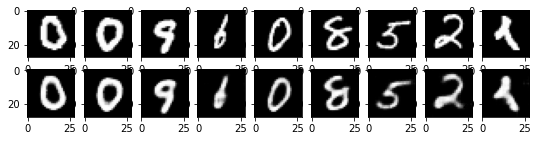

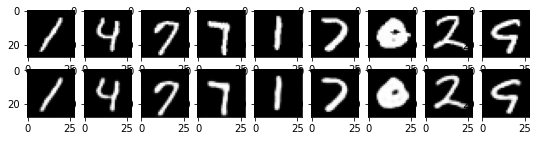

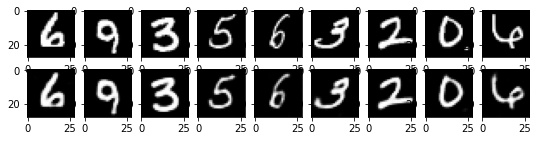

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

# plotting
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

### Reinforcement learning example

epoch: 0


Exception ignored in: <function Viewer.__del__ at 0x0000028803836670>
Traceback (most recent call last):
  File "c:\users\timok\documents\git_bachelor\flowmodeling\chapter_book\databook_python\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "c:\users\timok\documents\git_bachelor\flowmodeling\chapter_book\databook_python\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "c:\users\timok\documents\git_bachelor\flowmodeling\chapter_book\databook_python\lib\site-packages\pyglet\window\win32\__init__.py", line 328, in close
    super(Win32Window, self).close()
  File "c:\users\timok\documents\git_bachelor\flowmodeling\chapter_book\databook_python\lib\site-packages\pyglet\window\__init__.py", line 857, in close
    app.windows.remove(self)
  File "C:\Users\timok\Python\py390\lib\_weakrefset.py", line 110, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000002887FD

epoch: 5


C:\Users\timok\AppData\Local\Temp/ipykernel_19244/632359181.py:134: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  non_final_next = Variable(torch.cat([s for s in batch[2] if s is not None]), volatile=True)
C:\Users\timok\AppData\Local\Temp/ipykernel_19244/632359181.py:141: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  next_value[non_final] = model(non_final_next).max(1)[0]
C:\Users\timok\AppData\Local\Temp/ipykernel_19244/632359181.py:142: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_value.volatile = False
C:\Users\timok\AppData\Local\Temp/ipykernel_19244/632359181.py:144: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please 

epoch: 10
epoch: 15
epoch: 20
epoch: 25
epoch: 30
epoch: 35
epoch: 40
epoch: 45


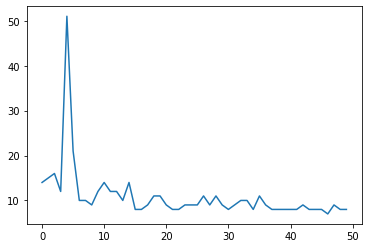

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import gym
import random
import numpy as np
from PIL import Image
import math
from itertools import count

# environment
env = gym.make('CartPole-v0').unwrapped
# dass es überall läuft
if 'inline' in matplotlib.get_backend():
    from IPython import display
    
# interactive plotting
plt.ion()

# all tensors on the GPU
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
ByteTensor = torch.ByteTensor
Tensor = FloatTensor

class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        # cyclic list
        self.pos = 0
        
    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.pos] = (state, action, next_state, reward)
        self.pos = (self.pos + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.conv1 = nn.Conv2d(3,16, kernel_size=5, stride=2)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)    
        self.norm3 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(448,2)
        
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        return self.fc(x.view(x.size(0), -1))

    
resize = T.Compose([
    T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()
])
    
width = 600

def cart_pos():
    env_width = env.x_threshold * 2
    return int(env.state[0] * width/env_width + width / 2.0)

def get_image():
    # wir brauchen CHW (channel width, height), wir bekommen ein anderes Format 
    screen = env.render(mode='rgb_array').transpose(
        (2,0,1)
    )
    screen = screen[:, 160:320]
    view = 320
    cart = cart_pos()
    # center the cart
    if cart < view // 2:            # floor division --> abgerundet
        sliced = slice(view)
    elif cart > width - view // 2:
        sliced = slice(-1*view, None)
    else:
        sliced = slice(cart - view // 2, cart + view // 2)
    screen = screen[:,:,sliced]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).type(Tensor)
        
#env.reset()
#plt.figure()
#plt.imshow(get_image().cpu().squeeze(0).permute(1,2,0).numpy(), interpolation='none')
#plt.show()

# model
model = net()
#model = model.cuda()
optimizer = optim.RMSprop(model.parameters())
mem = Memory(16300)
done = 0

eps_end = 0.95
eps_start = 0.95
eps_steps = 150
batch_size = 128
# for reward
gamma = 0.99
def get_action(state):
    global done
    epsilon = random.random()
    threshold = (eps_end + eps_start - eps_end) * math.exp(-1. * done / eps_steps)
    done = done + 1
    if epsilon > threshold:
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1,1)
    else:
        return LongTensor([[random.randint(0,1)]])

# q - learning
def train():
    if len(mem) < batch_size:
        return
    x = mem.sample(batch_size)         # (state, action, next_state, reward)
    batch = tuple(zip(*x))                 # ((s1,s2, ...), (a1,a2,...), (n1, n2, ...), (r1,r2,...))
    non_final = ByteTensor(tuple(map(lambda s: s is not None, batch[2])))
    non_final_next = Variable(torch.cat([s for s in batch[2] if s is not None]), volatile=True)
    state = Variable(torch.cat(batch[0]))
    action = Variable(torch.cat(batch[1]))
    reward = Variable(torch.cat(batch[3]))
    action_value = model(state).gather(1, action)
    # v - value
    next_value = Variable(torch.zeros(batch_size).type(FloatTensor))
    next_value[non_final] = model(non_final_next).max(1)[0]
    next_value.volatile = False
    target_action_value = (next_value * gamma) + reward
    loss = F.smooth_l1_loss(action_value, target_action_value)
    optimizer.zero_grad()
    loss.backward()
    
    for p in model.parameters():
        p.grad.data.clamp_(-1,1)
    optimizer.step()
    

    
made_it = []
train_duration = 50
for i in range(train_duration):
    if i % (train_duration / 10) == 0:
        print('epoch:', i)
    env.reset()
    last = get_image()
    current = get_image()
    state = current - last
    for j in count():
        action = get_action(state)
        _,reward, lost, _ = env.step(int(action[0,0]))
        reward = Tensor([reward])
        
        last = current
        current = get_image()
        if lost:
            next_state = None
        else:
            next_state = current - last
        
        mem.push(state, action, next_state, reward)
        state = next_state
        train()
        if lost:
            made_it.append(j)
            #show()
            break
        
        
#env.render(close= True)
env.close()
plt.ioff()
plt.figure()
plt.plot(made_it)
plt.show()